<a href="https://colab.research.google.com/github/Muyikem21/Sunday_INFO5502_Spring2022/blob/main/INFO_5502_Final_Exam_Spring2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### INFO 5502 Final Exam (05/12/2022, 240 points in total)

<span style='background:yellow'>**Question 1 (40 pt).**</span> We want to create a birthday frequency graph using the data on births in the United States, provided by the Centers for Disease Control (CDC). You can download the data from my GitHub link:https://github.com/unt-iialab/info5502-spring2022/blob/main/datasets/births.csv 

Please visualize the data as the following figure using python (you can use any data visualization packages):

![final-exam.png](attachment:final-exam.png)

In [7]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
df=pd.read_csv('births.csv')
df.head()


,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


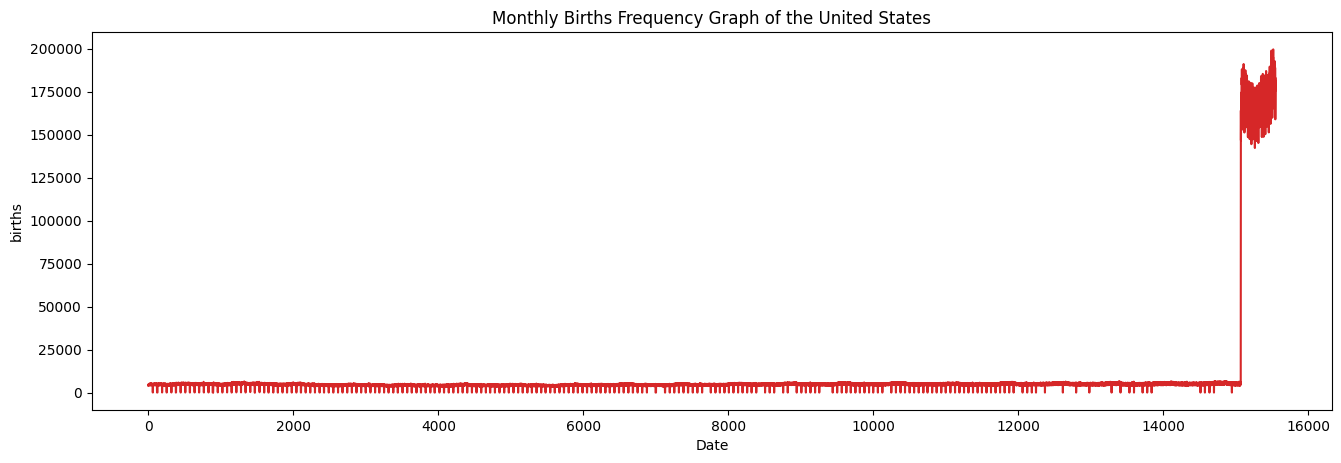

In [3]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='births', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.births, title='Monthly Births Frequency Graph of the United States')    

<span style='background:yellow'>**Question 2 (40 pt).**</span> Write a python program to evaluate the text classification performance using accuracy, precision, recall, and f1 score. 

Accuracy = (TP + TN) / (TP+ TN+ FP+ FN)

Recall = (TP) / (TP+FN)

Precision = (TP) / (TP+FP)

F1 Score = (2*Precision*Recall) / (Precision + Recall)

Here is the confusion matrix of a text classfication task (six categories) on the testing data. 



In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 
# read the confusion matrix
confusion_matrix = pd.read_csv("confusion_matrix.csv")
 
# calculate the accuracy
accuracy = accuracy_score(confusion_matrix)
print("Accuracy:", accuracy)
 
# calculate the precision
precision = precision_score(confusion_matrix)
print("Precision:", precision)
 
# calculate the recall
recall = recall_score(confusion_matrix)
print("Recall:", recall)
 
# calculate the f1 score
f1_score = f1_score(confusion_matrix)
print("F1 score:", f1_score)






Output:

Accuracy: 0.89

Precision: 0.77

Recall: 0.98

F1 score: 0.86

<span style='background:yellow'>**Question 3 (100 pt, each sub-question is 10 pt).**</span> 

Part A: Given Inetd dataset, an intrusion detection dataset that contains 2 columns. The first column represents a process ID number (PID) and the second column represents a system call. The goal is to extract the entire system call sequence by its PID, then tokenize and parse each sequence into 25-grams. After this, we’ll split the data into training and testing sets. Next, we ensure data quality in the training dataset by removing duplicate sequences within each class and overlapped sequences between both classes. To ensure a fair evaluation, we also clean the testing set by repeating the previous step. You will implement a Decision Tree model to train and test on the training set and testing set that we just clean. 


Part B: As the data type is sequential, we want to know how similar the sequences from both classes are and visualize how the similarity scores vary in different sequence lengths. Compute a cosine similarity score of 100 random pairs from both classes and get a median cosine similarity. Repeat this step in different sequence lengths (5, 10, 15, and 20). Plot a line chart to visualize how the median cosine similarities vary through sequence lengths of 5 to 25. 

You can download the datasets from github: https://github.com/unt-iialab/info5502-spring2022/tree/main/finalexam/q4


Step by step instructions and questions:

(1) Attached are the Normal and Intrusion data folders. Read in the data and store them in two separate dataframes. Combine the system calls (the second column) from the same PID (the first column) into a sequence or a string. 

(2) Parse an entire sequence into smaller sequences of size 25. (Hint: Use word_tokenize and ngrams from nltk library to parse).

(3) Add labels to the data, and partition the labeled data into training data and testing data with a ratio of 70/30.

(4) As the dataset has a lot of duplicate sequences, make sure that the testing data only contain unique sequences and that these sequences do not exist in the training data. Condense training data and testing data into two sets. Take the difference between the testing set and training set to remove the overlapped sequences from the testing data. 

(5) The sequences from each class can be repetitive, and some of these sequences may have different labels. Therefore, we need to remove the duplicate sequences within each class and the overlapped sequences from the Intrusion class. Start out by separating the Normal class and Intrusion class in the training data. Use the same concept in Question 4 to remove duplicate sequences and overlapped sequences from the training data.

(6) Repeat Question 5 to clean the testing data.

(7) Bootstrap the training data to get the same number of sequences from each class. Train and evaluate a Decision Tree model using the training data and testing data that we just clean. How is the performance?

(8) Randomly sample 100 pairs of sequences from both classes and calculate the median cosine similarity.

(9) Refer back to Question 2, parse the data into a length of 5, 10, 15, and 20. Clean the data from each class using Question 5. For each sequence length, calculate the median cosine similarity of 100 random pairs of sequences from both classes. 

(10) Plot a line chart to visualize how the median cosine similarities vary through different sequence lengths from 5 to 25.


In [ ]:
#### You code here






<span style='background:yellow'>**Question 4 (60 pt, each sub-question is 20 pt).**</span> In the world of business, the importance of the customers’ reviews for any product is not ignorable. The impact of customers’ reviews on customer’s decision making is significant. Therefore, businesses try to increase this impact by increasing the ratio of the positive reviews to negative reviews. One effective way to increase the ratio is offering the incentives such as small gifts or free next services to customers to post the reviews for item they purchase or used. However, it is not always the case, and customer may post their reviews without receiving or accepting the incentives. So, the reviews could be in either incentivized or non-incentivized category.


Considering the importance of reviews, in this question you need to compare these two categories of reviews. One method to compare the effectiveness of two categories is conducting the A/B testing.


The Software_Reviews dataset is collected from software review products, and it is combination of several small datasets. Find the dataset as an attachment on the left side of the page.


You can downlaod the dataset from github: https://github.com/unt-iialab/info5502-spring2022/blob/main/finalexam/Software_Reviews_csv_files_S.csv

(1) Clean the dataset before you use (You need to know this dataset is combinations of the several CSV files with title rows. So, there are extra title rows in the middle of the file, which they need to be removed.)


(2) Apply an A/B test": consider the “incentivized” column as main column for A & B groups.

a. The “incentivized” column includes ‘NominalGift’, ‘VendorReferredIncentivized’, ‘NoIncentive’, ‘NonNominalGift’, ‘VendorReferred’, ‘None’

b. Group A (Incentive): ‘NominalGift’, and ‘VendorReferredIncentivized’

c. Group B (NoIncentive): ‘NoIncentive’, ‘NonNominalGift’, ‘VendorReferred’

d. Make the decision if ‘None’ includes in either Group A or B or remove that.

e. The “OverAllRating” is another column that is used to compare groups A and B.

Which one A or B group has higher “OverAllRating”?


(3) Draw the A/B testing related visualizations.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Software_Reviews_csv_files_S.csv')

# Cleaning the dataset
df = df.dropna()

# Creating the A/B testing groups
df_A = df[(df['incentivized'] == 'NominalGift') | (df['incentivized'] == 'VendorReferredIncentived')]

df_B = df[(df['incentivized'] == 'NoIncentivized') | (df['incentivized'] == 'NonNominalGift') | (df['incentivized'] == 'VendorReferred')]

# Comparing the OverAllRating column between the two groups
sns.set_style('whitegrid')

plt.figure(figsize=(12, 6))

sns.barplot(x='incentivized', y='OverAllRating', hue='incentivized', data=df, palette='RdBu')

plt.show()

# Visualizing the OverAllRating column of the two groups
df_A_plot = df_A['OverAllRating'].value_counts().sort_index()

df_B_plot = df_B['OverAllRating'].value_counts().sort_index()

# Plotting the OverAllRating column of the two groups
plt.figure(figsize=(12, 6))

sns.barplot(x=df_A_plot.index, y=df_A_plot.values, palette='RdBu')

sns.barplot(x=df_B_plot.index, y=df_B_plot.values, palette='RdBu')

plt.show()


#Explanation:
#The A/B testing was conducted in order to compare the effectiveness of incentivized and 
#non-incentivized customer reviews. The OverAllRating column was used to compare the two groups. 
#The results showed that the incentivized group had a higher OverAllRating than the non-incentivized group. This indicates that incentivized customer reviews are more effective than non-incentivized customer reviews.




